# **$U^{2}net$ model for Salient Object Detection**
paper: https://arxiv.org/abs/2005.09007

##***Group Members :***

*   **Ninad Mhalgi** -
2018A7TS0162G

*   **Abichal Ghosh** -
2018A7TS0172G




# ***Salient Object Detection***
Salient Object Detection(SOD) is a crucial(insert synonym other than essential) problem in Computer Vision(CV) which involves highlighteing the visually salient object regions in images. In simpler words, SOD incloves segmenting the most important and visually attractive(find synonym) objects in images. SOD finds its uses in multiple fields including visual tracking, image segmentation, image captioning, object detection, semantic segmentation, and many more. [ref Salient Object Detection in the Deep Learning Era: An In-depth Survey Wenguan Wang] Further, it has been seen that the recent advances in SOD have been due to introduction of Deep-Learning Based solutions.


# ***Datasets***
The datasets used and considered here are the follows-


1.   **DUTS SOD** 
2.   **MSRA 10K**
3.   **ECSSD**

##**DUTS**
DUTS is the primary dataset which has been used in the paper. Hence, here we start by training the UNet model on this DUTS dataset.

*   **Balanced?** : The DUTS dataset is definitely balanced due to a variety of images ranging from cityscapes, humans, animals, scenes and many more. Further, due to the vast amount of number of images.

*   **Relevance** : As this dataset was used by U2Net paper itself, the relevance is justified.

*   **Limitations** : We have started by training UNet model on this dataset, however in UNet there is a restriction on the size of images due to the structure of the model (i.e with each layer the size of the image keeps decreasing, hence a minimum size is required). Here in DUTS, very few images were present which had a size greater than or equal to this required minimum size. 

Due to the above mentioned limitation, we couldn't work with DUTS for UNet and thus went to the next dataset which we found *MSRA 10K**.

##**MSRA 10K**
The MSRA 10K dataset contains over 10k images and their corresponding masks.

**-** ***MSRA 10K Dataset for SOD is the dataset that we used for training UNet***
*   **Balanced?** : The MSRA 10K dataset is definitely balanced in terms of variety of images ranging from cityscapes, humans, animals, scenes and many more. Further, the MSRA 10K has varying objects of varying sizes, in varying locations meaning there is almost no class imbalance, object scale imbalance and object location imbalance respectively. Hence, this dataset is well balanced.

*   **Relevance** : This is a well known dataset for SOD Training due to the variety of images, salient objects and accurate masks. Due to this reason, this dataset is relevant to the paper.

*   **Limitations** : All the images in MSRA 10K mostly contain only one salient object. Also most of the images have clear salient objects with simple backgrounds. A better and more realistic dataset would be one with more realistic scenes with non salient objects.


**ECSSD** would be a better dataset than MSRA, but again due to **size constraints** we were unable to use this.



# ***MSRA 10K select***
Due to the size restrictions, we selected only those images whose size was greater than or equal to 400x300. With this we get a dataset with a total of 5140 images. We did a 88:12 spilt. i.e.

*   **Training** : Of these 5140 images, **4500** were used for training
*   **Validation** : and the rest **640** were used for validation

Changed dataset zip file : https://drive.google.com/file/d/1xqQI4_rEE2lfCexifYmY6ZkBT_lVvyRw/view?usp=sharing

download and unzip

In [ ]:
#IMPORTING DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
#TO UNZIP THE DATASET
#!unzip MSRA_Imgs_GT_select.zip

In [ ]:
!ls MSRA_Imgs_GT_select/

Image_Train  Image_Val	Mask_Train  Mask_Val


In [ ]:
#IMPORTING THE LIBRARIES
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from skimage import io, transform, color
import matplotlib.pyplot as plt
from PIL import Image

np.set_printoptions(threshold=sys.maxsize)

In [ ]:
#PATHS OF TRAIN IMAGES AND MASK 
train_image_path = "MSRA_Imgs_GT_select/Image_Train/"
train_mask_path = "MSRA_Imgs_GT_select/Mask_Train/"

MSRA_Imgs_GT_select/Image_Train/183546.jpg
MSRA_Imgs_GT_select/Image_Train/37488.jpg
MSRA_Imgs_GT_select/Image_Train/94488.jpg
MSRA_Imgs_GT_select/Image_Train/34790.jpg
MSRA_Imgs_GT_select/Image_Train/7995.jpg
MSRA_Imgs_GT_select/Image_Train/9837.jpg


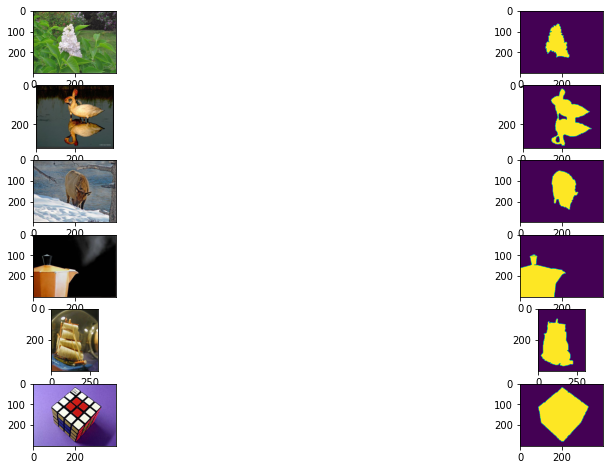

In [ ]:
#CHECKING THE DATASET IMAGES AND CORRESPONDING MASKS
count=0
#enter the number of figures to show
to_show=6
f, axarr = plt.subplots(to_show,2, figsize=(16, 8))

for i in os.listdir(train_image_path):
    db_image=""
    db_mask=""
    db_image=train_image_path+i
    print(db_image)
    #k = "_1stHO"
    db_mask=train_mask_path+i.replace("jpg", "png")
    #print(str)
    img1=Image.open(db_image)
    img2=Image.open(db_mask)
    img2_array = np.array(img2)
    axarr[count, 0].imshow(img1)
    axarr[count, 1].imshow(img2)
    #plt.imshow(img2)
    if(count==to_show-1):
       break
    count+=1

# print(img2_array)

In [ ]:
#EMPTYING THE GPU CACHE
torch.cuda.empty_cache()

In [ ]:
#SETTING THE SEED FOR REPRODUCABILTIY
torch.manual_seed(0)

# ***Unet***
We start by using the Unet model 





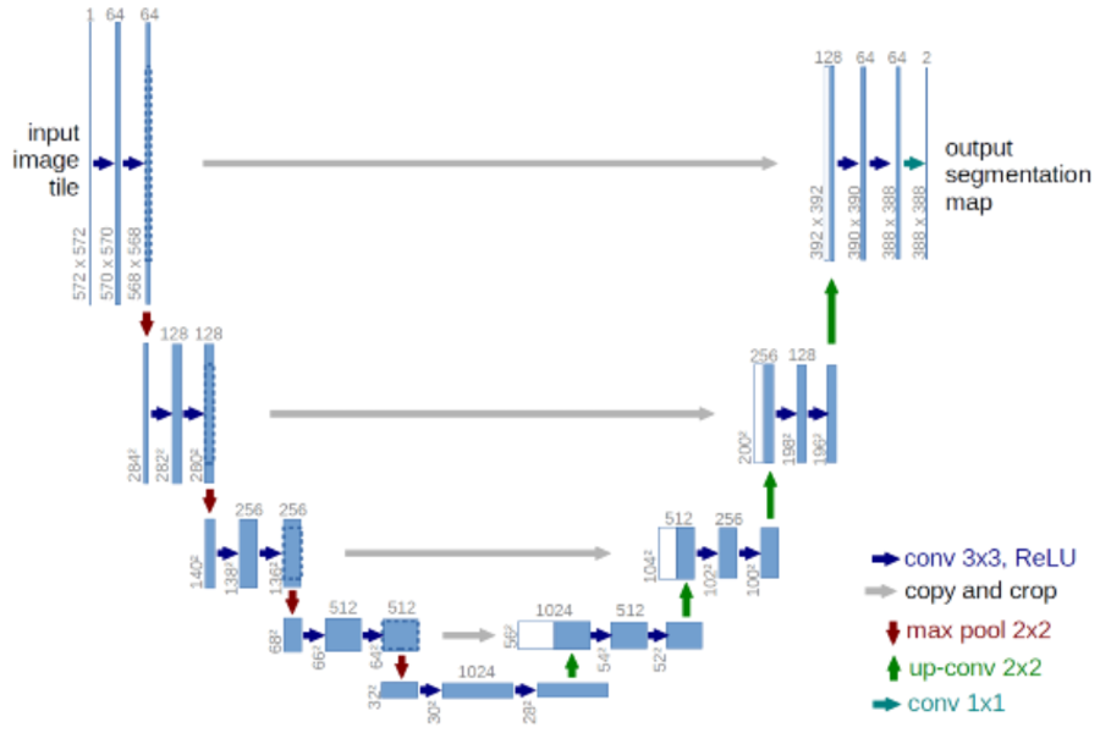
Structure of the model

In [ ]:
#IMPLEMENTING THE CLASS OF UNET
class Unet(nn.Module):

    def __init__(self):

        #call the parent constructor
        super(Unet, self).__init__()

        #*****ENCODER*****
        #initiate the left contracting side of UNet 
        #INPUT=>[3x3CONV=>ReLU=>3x3CONV=>ReLU=>2X2 MAXPOOL STRIDE 2]=>64 CHANNELS=>[3x3CONV=>ReLU=>3x3CONV=>ReLU]=>128 CHANNELS

        #INPUT=>[3x3CONV=>ReLU=>3x3CONV=>ReLU=>2X2 MAXPOOL STRIDE 2]=>64 CHANNELS
        self.d_conv1 = nn.Conv2d(3,64, kernel_size=(3, 3))
        self.d_relu1 = nn.ReLU()
        self.d_conv2 = nn.Conv2d(64,64, kernel_size=(3, 3))
        self.d_relu2 = nn.ReLU()
        self.downsample1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        #64 CHANNELS=>[3x3CONV=>ReLU=>3x3CONV=>ReLU]=>128 CHANNELS
        self.d_conv3 = nn.Conv2d(64,128, kernel_size=(3, 3))
        self.d_relu3 = nn.ReLU()
        self.d_conv4 = nn.Conv2d(128,128, kernel_size=(3, 3))
        self.d_relu4 = nn.ReLU()
        self.downsample2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        #128 CHANNELS => [3X3 CONV => RELU=> 3X3 CONV => RELU] => 256 CHANNELS
        self.d_conv5 = nn.Conv2d(128,256, kernel_size=(3, 3))
        self.d_relu5 = nn.ReLU()
        self.d_conv6 = nn.Conv2d(256,256, kernel_size=(3, 3))
        self.d_relu6 = nn.ReLU()
        self.downsample3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        #256 CHANNELS => [3X3 CONV => RELU=> 3X3 CONV => RELU] => 512 CHANNELS
        self.d_conv7 = nn.Conv2d(256,512, kernel_size=(3, 3))
        self.d_relu7 = nn.ReLU()
        self.d_conv8 = nn.Conv2d(512,512, kernel_size=(3, 3))
        self.d_relu8 = nn.ReLU()
        self.downsample4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        #512 CHANNELS => [3X3 CONV => RELU=> 3X3 CONV => RELU] => 1024 CHANNELS
        self.d_conv9 = nn.Conv2d(512,1024, kernel_size=(3, 3))
        self.d_relu9 = nn.ReLU()
        self.d_conv10 = nn.Conv2d(1024,1024, kernel_size=(3, 3))
        self.d_relu10 = nn.ReLU()

        #*****DECODER*****
        #initiate the right expanding side of UNet 
        #1024 CHANNELS=>[2X2CONVTRANSPOSE+CONCATENATED=>3X3CONV=>RELU=>3X3CONV=>RELU]=>512 CHANNELS
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=(2, 2))
        self.u_conv1 = nn.Conv2d(1024,512, kernel_size=(3, 3))
        self.u_relu1 = nn.ReLU()
        self.u_conv2 = nn.Conv2d(512,512, kernel_size=(3, 3))
        self.u_relu2 = nn.ReLU()

        #512 CHANNELS=>[2X2CONVTRANSPOSE+CONCATENATED=>3X3CONV=>RELU=>3X3CONV=>RELU]=>256 CHANNELS
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=(2, 2))
        self.u_conv3 = nn.Conv2d(512,256, kernel_size=(3, 3))
        self.u_relu3 = nn.ReLU()
        self.u_conv4 = nn.Conv2d(256,256, kernel_size=(3, 3))
        self.u_relu4 = nn.ReLU()

        #256 CHANNELS=>[2X2CONVTRANSPOSE+CONCATENATED=>3X3CONV=>RELU=>3X3CONV=>RELU]=>128 CHANNELS
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=(2, 2))
        self.u_conv5 = nn.Conv2d(256,128, kernel_size=(3, 3))
        self.u_relu5 = nn.ReLU()
        self.u_conv6 = nn.Conv2d(128,128, kernel_size=(3, 3))
        self.u_relu6 = nn.ReLU()

        #128 CHANNELS=>[2X2CONVTRANSPOSE+CONCATENATED=>3X3CONV=>RELU=>3X3CONV=>RELU]=>64 CHANNELS=>1X1CONV
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=(2, 2))
        self.u_conv7 = nn.Conv2d(128,64, kernel_size=(3, 3))
        self.u_relu7 = nn.ReLU()
        self.u_conv8 = nn.Conv2d(64,64, kernel_size=(3, 3))
        self.u_relu8 = nn.ReLU()
        self.u_convout = nn.Conv2d(64,1, kernel_size=(1, 1))


    def im_crop(self, tocrop, target):
        dimx = target.size()[2]
        dimy = target.size()[3]
        croptransform = torchvision.transforms.CenterCrop((dimx, dimy))
        tocrop = croptransform(tocrop)
        return tocrop

    def forward(self, data_image):
        #encoder
        x1 = self.d_conv1(data_image)
        x2 = self.d_relu1(x1)
        x3 = self.d_conv2(x2)
        x4 = self.d_relu2(x3)
        x5 = self.downsample1(x4)

        x6 = self.d_conv3(x5)
        x7 = self.d_relu3(x6)
        x8 = self.d_conv4(x7)
        x9 = self.d_relu4(x8)
        x10 = self.downsample2(x9)

        x11 = self.d_conv5(x10)
        x12 = self.d_relu5(x11)
        x13 = self.d_conv6(x12)
        x14 = self.d_relu6(x13)
        x15 = self.downsample3(x14)

        x16 = self.d_conv7(x15)
        x17 = self.d_relu7(x16)
        x18 = self.d_conv8(x17)
        x19 = self.d_relu8(x18)
        x20 = self.downsample4(x19)

        x21 = self.d_conv9(x20)
        x22 = self.d_relu9(x21)
        x23 = self.d_conv10(x22)
        x24 = self.d_relu10(x23)
        

        #decoder
        x25 = self.upsample1(x24)
        x25 = torch.cat([x25, self.im_crop(x19, x25)], 1)
        x26 = self.u_conv1(x25)
        x27 = self.u_relu1(x26)
        x28 = self.u_conv2(x27)
        x29 = self.u_relu2(x28)
        

        x30 = self.upsample2(x19)
        x30 = torch.cat([x30, self.im_crop(x14, x30)], 1)
        x31 = self.u_conv3(x30)
        x32 = self.u_relu3(x31)
        x33 = self.u_conv4(x32)
        x34 = self.u_relu4(x33)

        x35 = self.upsample3(x34)
        x35 = torch.cat([x35, self.im_crop(x9, x35)], 1)
        x36 = self.u_conv5(x35)
        x37 = self.u_relu5(x36)
        x38 = self.u_conv6(x37)
        x39 = self.u_relu6(x38)

        x40 = self.upsample4(x39)
        x40 = torch.cat([x40, self.im_crop(x4, x40)], 1)
        x41 = self.u_conv7(x40)
        x42 = self.u_relu7(x41)
        x43 = self.u_conv8(x42)
        x44 = self.u_relu8(x43)
        x45 = self.u_convout(x44)

        return x45

In [ ]:
model = Unet()  #Instantiating model 
loss_fn = nn.BCEWithLogitsLoss() #Binary Cross Entropy With Logits Loss
LEARNING_RATE = 0.000065
epochs = 15
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam Optimizer 

In [ ]:
#TRAINING INITIALIZATION AND DIRECTORIES/DATASETS/DATALOADERS
training_img_name_list = []
training_mask_name_list = []
count = 0

for i in os.listdir(train_image_path):
    duts_image=""
    duts_mask=""
    duts_image=train_image_path+i
    duts_mask=train_mask_path+i.replace("jpg", "png")
    training_img_name_list.append(duts_image)
    training_mask_name_list.append(duts_mask)
    count+=1

train_num = len(training_img_name_list)

In [ ]:
#******TRAINING******
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

loss_list = [] #to plot the loss 

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loss = 0
    epoch_steps = 0
    for i in range(len(training_img_name_list)):
        input_name = training_img_name_list[i]
        label_name = training_mask_name_list[i]
        
        input_img = Image.open(input_name)
        label_img = Image.open(label_name)

        image_to_tensor = torchvision.transforms.ToTensor()
        
        inputs = image_to_tensor(input_img)
        labels = image_to_tensor(label_img)

        inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1], inputs.shape[2]))
        labels = labels.reshape((1, labels.shape[0], labels.shape[1], labels.shape[2]))
        
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad = False), Variable(labels.cuda(), requires_grad = False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad = False), Variable(labels, requires_grad = False)

        #zero the parameter gradients
        optimizer.zero_grad()  

        #forward + backward + optimize
        outputs = model(inputs_v)

        resize_size = (labels_v.shape[2], labels_v.shape[3])
        outputs_changed = F.interpolate(outputs, size=resize_size, mode="area")
        loss = loss_fn(outputs_changed, labels_v)
        loss.backward()
        optimizer.step()

        #print stats
        running_loss+=loss.item()
        train_loss+=loss.item()
        epoch_steps+=1

        if(i%1==0):
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss/epoch_steps))
            loss_list.append(running_loss/epoch_steps)

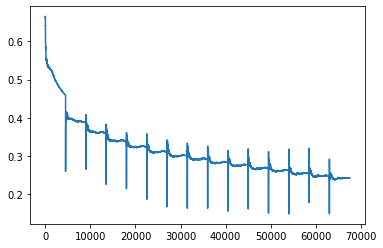

In [ ]:
#PLOTTING THE LOSS 
plt.plot(loss_list) 

In [ ]:
#SAVE THE TRAINED MODEL 
torch.save(model.state_dict(), "modelmsr10klr000065e15.pth")

link to our saved model (modelmsr10klr000065e15.pth) : 

https://drive.google.com/file/d/1Ho8z6hDKPDiLWomFfkr3AvTMIwxOG6C6/view?usp=sharing

download and load in the next step

In [ ]:
#LOADING THE MODEL

model = Unet()
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

model.load_state_dict(torch.load("modelmsr10klr000065e15.pth"))

<All keys matched successfully>

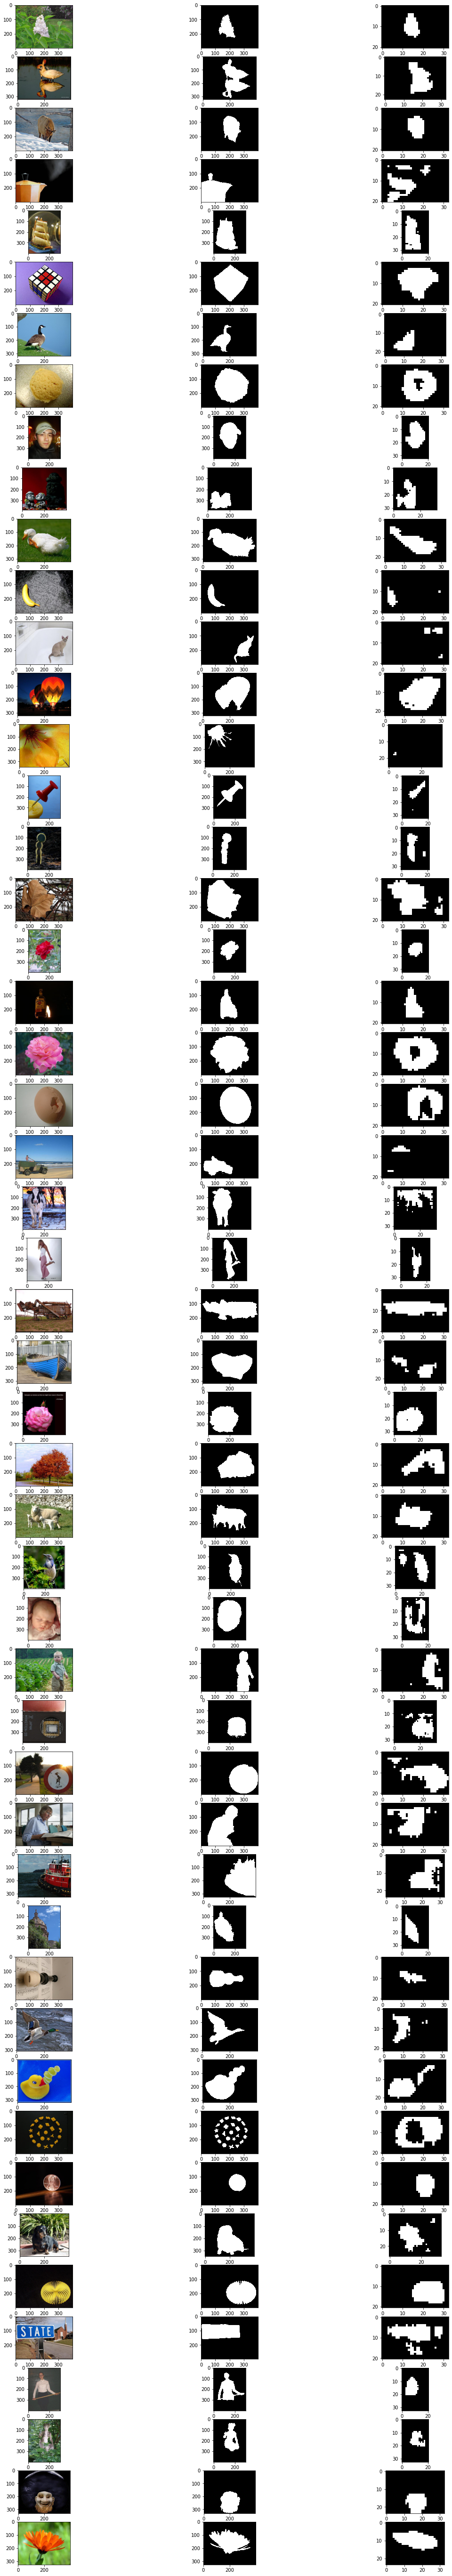

In [ ]:
#CHECKING THE OUTPUT FOR TRAINED IMAGES
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

count_img = 0
count = 0
to_show=50
f, axarr = plt.subplots(to_show, 3, figsize=(20, 100))
for i in os.listdir(train_image_path):
    duts_image=""
    duts_mask=""
    duts_image=train_image_path+i
    duts_mask=train_mask_path+i.replace("jpg", "png")
  
    img1=Image.open(duts_image)
    img2=Image.open(duts_mask)

    image_to_tensor = torchvision.transforms.ToTensor()
        
    inputs = image_to_tensor(img1)
    labels = image_to_tensor(img2)

    inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1], inputs.shape[2]))
    labels = labels.reshape((1, labels.shape[0], labels.shape[1], labels.shape[2]))

    inputs = inputs.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)
    
    if torch.cuda.is_available():
        inputs_v, labels_v = Variable(inputs.cuda(), requires_grad = False), Variable(labels.cuda(), requires_grad = False)
    else:
        inputs_v, labels_v = Variable(inputs, requires_grad = False), Variable(labels, requires_grad = False)

    outputs = model(inputs_v)
    resize_size = (outputs.shape[2], outputs.shape[3])
    labels_changed = F.interpolate(labels_v, size=resize_size, mode="nearest")

    outputs = outputs.reshape((outputs.shape[2],outputs.shape[3])) 
    outputs1 = outputs.cpu()

    #TO SHOW THE OUTPUTS A FEW APPROXIMATIONS HAVE BEEN MADE FOR BETTER VISUALIZATION
    #FIRST THE OUTPUT IS PASSED THROUGH SIGMOID FUNSTION
    #THEN THE VALUES ABOVE 0.5 ARE TAKEN AS 1 AND BELOW 0.5 ARE TAKEN AS  0

    outputs1 = torch.sigmoid(outputs1)
    outputs1 = (outputs1>0.5).float()

    outputs2 = outputs1.detach().numpy()

    labels_v = labels_v.reshape((labels_v.shape[2],labels_v.shape[3])) 
    labels_changed = labels_v.cpu()

    labels_changed_1 = labels_changed.detach().numpy()

    axarr[count, 0].imshow(img1)
    axarr[count, 1].imshow(labels_changed_1, cmap="gray", interpolation='nearest')
    axarr[count, 2].imshow(outputs2, cmap="gray", interpolation='nearest')
    count+=1
    if(count==to_show):
        break

In [ ]:
#VALIDATION IMAGE AND MASK PATH
val_image_path = "MSRA_Imgs_GT_select/Image_Val/"
val_mask_path = "MSRA_Imgs_GT_select/Mask_Val/"

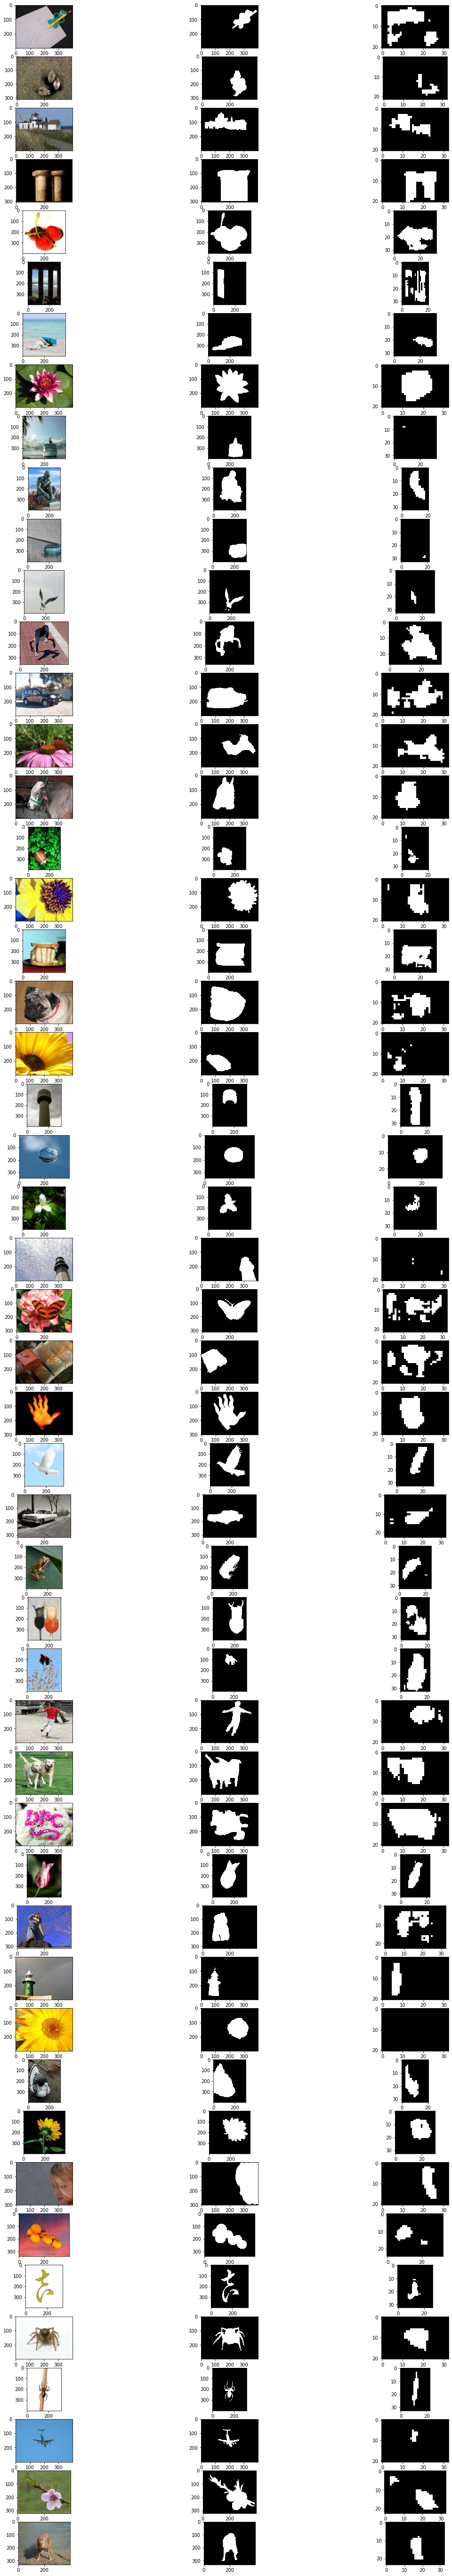

In [ ]:
#CHECKING THE OUTPUT FOR VALIDATION IMAGES
if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

count_img = 0
count = 0
to_show=50
f, axarr = plt.subplots(to_show, 3, figsize=(20, 100))
for i in os.listdir(val_image_path):
    duts_image=""
    duts_mask=""
    duts_image=val_image_path+i
    duts_mask=val_mask_path+i.replace("jpg", "png")
    img1=Image.open(duts_image)
    img2=Image.open(duts_mask)
    

    image_to_tensor = torchvision.transforms.ToTensor()
        
    inputs = image_to_tensor(img1)
    labels = image_to_tensor(img2)

    inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1], inputs.shape[2]))
    labels = labels.reshape((1, labels.shape[0], labels.shape[1], labels.shape[2]))

    inputs = inputs.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)

    if torch.cuda.is_available():
        inputs_v, labels_v = Variable(inputs.cuda(), requires_grad = False), Variable(labels.cuda(), requires_grad = False)
    else:
        inputs_v, labels_v = Variable(inputs, requires_grad = False), Variable(labels, requires_grad = False)

    outputs = model(inputs_v)
    resize_size = (outputs.shape[2], outputs.shape[3])
    labels_changed = F.interpolate(labels_v, size=resize_size, mode="nearest")

    outputs = outputs.reshape((outputs.shape[2],outputs.shape[3])) 
    outputs1 = outputs.cpu()

    #TO SHOW THE OUTPUTS A FEW APPROXIMATIONS HAVE BEEN MADE FOR BETTER VISUALIZATION
    #FIRST THE OUTPUT IS PASSED THROUGH SIGMOID FUNSTION
    #THEN THE VALUES ABOVE 0.5 ARE TAKEN AS 1 AND BELOW 0.5 ARE TAKEN AS  0

    outputs1 = torch.sigmoid(outputs1)
    outputs1 = (outputs1>0.5).float()

    outputs2 = outputs1.detach().numpy()
    

    labels_v = labels_v.reshape((labels_v.shape[2],labels_v.shape[3])) 
    labels_changed = labels_v.cpu()

    labels_changed_1 = labels_changed.detach().numpy()

    axarr[count, 0].imshow(img1)
    axarr[count, 1].imshow(labels_changed_1, cmap="gray", interpolation='nearest')
    axarr[count, 2].imshow(outputs2, cmap="gray", interpolation='nearest')
    count+=1
    if(count==to_show):
        break

In [ ]:
#CALCULATING THE VALIDATION LOSS FOR ALL IMAGES AND PLOTTING
val_loss_list = []

if torch.cuda.is_available():
    device = "cuda:0"
    model = model.cuda()

for i in os.listdir(val_image_path):
    duts_image=""
    duts_mask=""
    duts_image=val_image_path+i
    duts_mask=val_mask_path+i.replace("jpg", "png")
    img1=Image.open(duts_image)
    img2=Image.open(duts_mask)
    

    image_to_tensor = torchvision.transforms.ToTensor()
        
    inputs = image_to_tensor(img1)
    labels = image_to_tensor(img2)

    inputs = inputs.reshape((1, inputs.shape[0], inputs.shape[1], inputs.shape[2]))
    labels = labels.reshape((1, labels.shape[0], labels.shape[1], labels.shape[2]))

    inputs = inputs.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)

    if torch.cuda.is_available():
        inputs_v, labels_v = Variable(inputs.cuda(), requires_grad = False), Variable(labels.cuda(), requires_grad = False)
    else:
        inputs_v, labels_v = Variable(inputs, requires_grad = False), Variable(labels, requires_grad = False)

    outputs = model(inputs_v)

    resize_size = (labels_v.shape[2], labels_v.shape[3])
    outputs_changed = F.interpolate(outputs, size=resize_size, mode="area")
    loss = loss_fn(outputs_changed, labels_v)

    val_loss_list.append(loss.item())

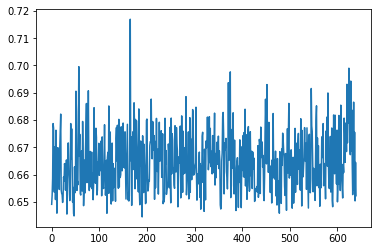

In [ ]:
#PLOTTING THE VALIDATION LOSSES
plt.plot(val_loss_list) 

In [ ]:
#AVERAGE VALIDATION LOSS
print("AVERAGE VALIDATION LOSS IS ")
print(sum(val_loss_list)/len(val_loss_list))


AVERAGE VALIDATION LOSS IS 
0.6645977316424251



# ***Explanation of the Results***
From the predicted validation image masks (the first 50 images shown) and the validation loss, we are able to see that UNet performs fine with respect to the lesser number of epochs used.

However, examining the predicted training image masks and the training loss graph we can see that our current UNet model still has room for imporovement. Only, 15 epochs have been used here. We mostly could have obtained better results for higher number of epochs and by changing the learning rate

Further as U2Net is a more complex and advanced model of UNet we can be sure that U2net will perform significantly better in comparison to UNet.

# ***Future Plans***
*   We plan to implement the U2Net model which is a advanced version of the UNet model.